<a href="https://colab.research.google.com/github/Satvik256/Random-Forest/blob/main/Random_Forest_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RANDOM FOREST FROM SCRATCH !!

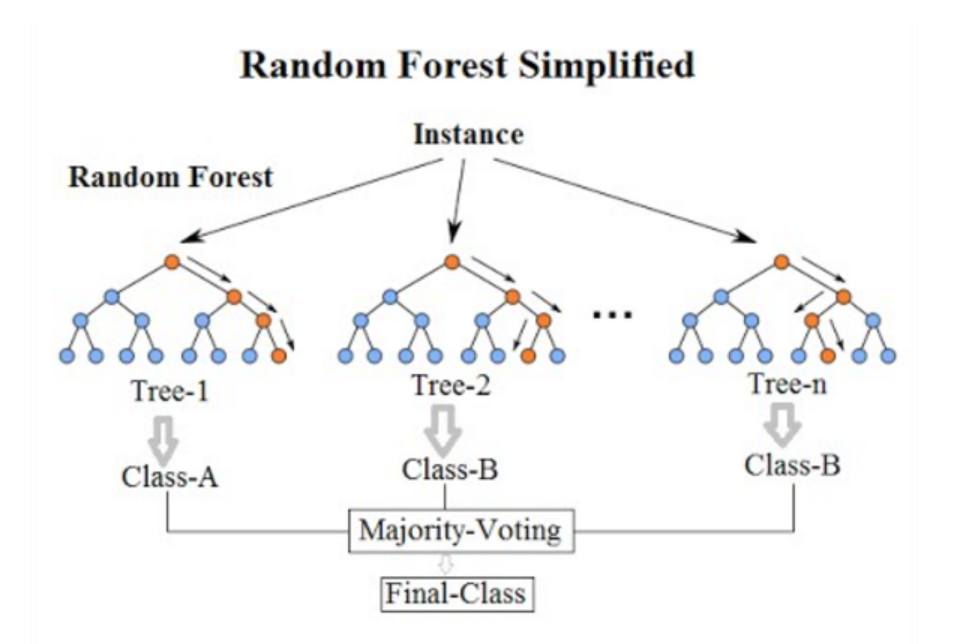

## The data

We will be analysing SUSY data from the [Searching for exotic particles in high-energy physics with deep learning](https://www.nature.com/articles/ncomms5308) article by Baldi et al. (2014). The dataset can be obtained from the [UCI Machine Learning repository](http://archive.ics.uci.edu/ml/datasets/SUSY#) and is described as follows:

> The data has been produced using Monte Carlo simulations. The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks and the dropout algorithm are presented in the original paper. The last 500,000 examples are used as a test set.

Framed as a supervised learning task, the goal is to train a model that can classify each event as either a SUSY signal or Standard Model background (see figure below)

The dataset description also provides information on the features or kinematic variables associated with with each event:

The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features): lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1).

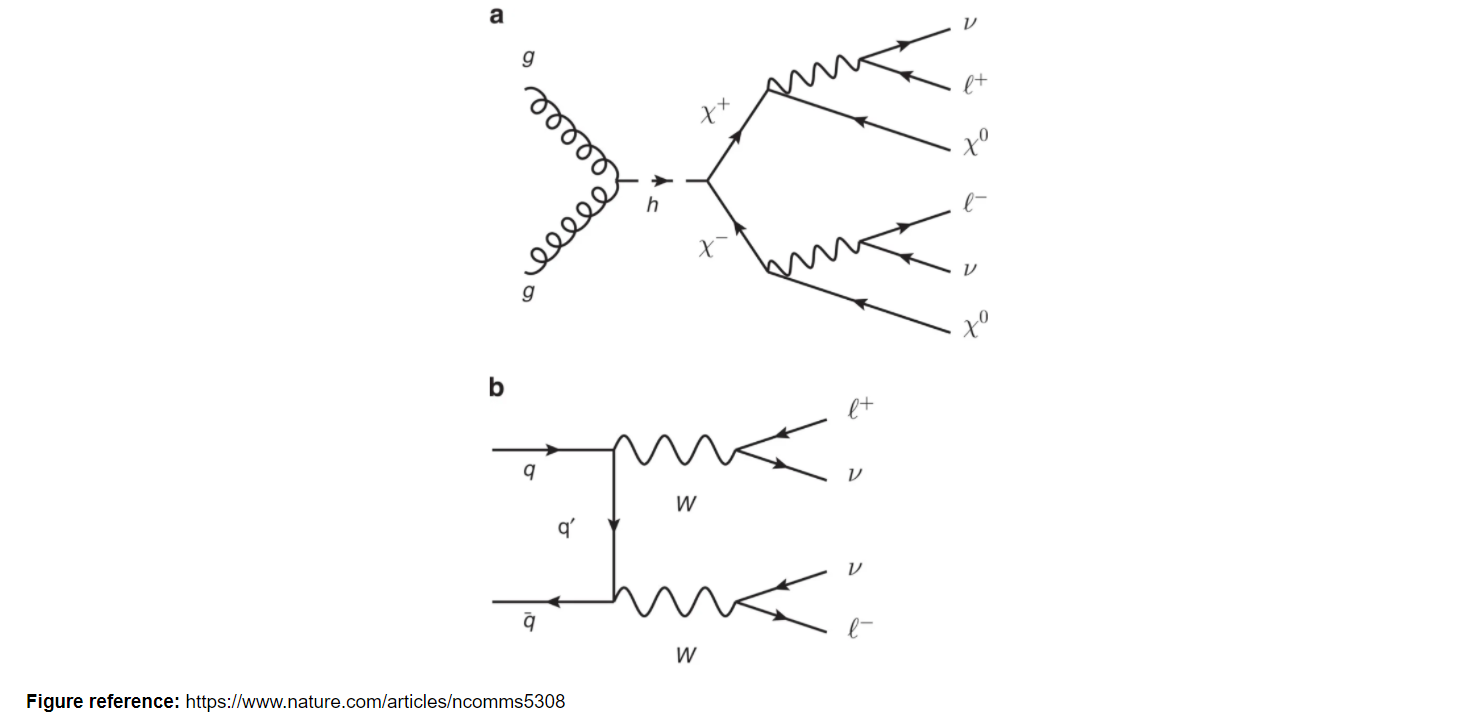

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install --upgrade hepml

     |████████████████████████████████| 1.5MB 6.0MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 1.1MB 17.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 13.1MB 243kB/s 
     |████████████████████████████████| 399kB 38.9MB/s 
     |████████████████████████████████| 3.2MB 43.6MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 747kB 38.1MB/s 
     |████████████████████████████████| 727kB 38.5MB/s 
  Created wheel for black: filename=black-20.8b1-cp36-none-any.whl size=124186 sha256=9dd5d423b3375e77d90c45dcdc2f36fee9c12a591da67b125a9ef7ea29dad676
  Stored in directory: /root/.cache/pip/wheels/6e/10/b5/edf7359c2edd0305cce7e3f96e07daf7ce55dceac9d3ce3373
Successfully built black
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=0a4fed498ca57

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from hepml.core import display_large, download_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
download_dataset("susy.csv.gz")

Download of susy.csv.gz dataset complete.


In [ ]:
DATA = Path("../data")
!ls {DATA}

susy.csv.gz


In [ ]:
columns = [
    "signal",
    "lepton 1 pT",
    "lepton 1 eta",
    "lepton 1 phi",
    "lepton 2 pT",
    "lepton 2 eta",
    "lepton 2 phi",
    "missing energy magnitude",
    "missing energy phi",
    "MET_rel",
    "axial MET",
    "M_R",
    "M_TR_2",
    "R",
    "MT2",
    "S_R",
    "M_Delta_R",
    "dPhi_r_b",
    "cos(theta_r1)",
]

In [ ]:
%time susy = pd.read_csv(DATA / "susy.csv.gz", compression="gzip", names=columns)

CPU times: user 34.6 s, sys: 1.17 s, total: 35.7 s
Wall time: 35.8 s


In [ ]:
susy.to_feather(DATA / "susy.feather")

##**DATA INTERPRETATION**

In [ ]:
susy.head(10)

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
5,0.0,0.456398,1.099371,1.512453,0.751772,0.638967,-0.742216,0.322601,1.321054,0.169502,0.359941,0.489256,0.416168,0.754829,0.303750,0.461067,0.345541,0.733242,0.186044
6,0.0,0.437818,-1.119883,-1.336823,0.502320,-1.717515,1.017067,0.215619,-0.461200,0.323671,0.173626,0.411898,0.370525,0.798260,0.671369,0.385910,0.515522,0.479110,0.029058
7,0.0,0.571656,0.205696,0.425950,0.578514,0.927399,-1.101478,0.116555,1.549753,0.174421,0.223450,0.523164,0.289889,0.491710,0.334593,0.514246,0.268207,0.315795,0.125728
8,1.0,2.112812,0.742983,-0.330539,0.805253,-0.028887,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
9,0.0,1.001869,-0.471788,0.555614,1.233368,1.255548,-1.052491,0.437615,-1.333052,0.326858,-0.111678,1.435708,0.755201,0.466779,0.454541,1.446331,0.592259,1.325197,0.083014


In [ ]:
susy.tail(10)

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
4999990,0.0,0.482755,1.204410,0.299445,0.780271,1.958697,0.938929,0.887801,-1.404129,1.332697,-0.456543,0.551233,0.957969,1.542171,1.982478,0.579808,1.481396,1.006600,0.189843
4999991,1.0,1.031701,0.648011,-1.616710,0.532912,1.663047,-1.243807,0.706740,0.189915,0.433557,-0.393302,0.809631,1.087218,1.191645,1.972363,0.698013,1.564201,0.035361,0.504437
4999992,0.0,1.085361,0.861342,-1.356951,0.483685,0.059381,0.292341,0.340940,0.761038,0.380255,0.038984,0.774140,0.660777,0.757443,0.331105,0.715807,0.447304,0.320159,0.371521
4999993,0.0,1.339252,-1.753881,0.667430,1.279321,-0.125801,-1.025262,0.996305,-1.425422,1.005658,-0.529824,1.616218,1.278956,0.702218,0.541788,1.649413,1.139551,1.256152,0.159157
4999994,0.0,0.726624,0.098401,-0.917547,0.477953,-0.297608,1.398104,0.372883,0.774908,0.508651,-0.040399,0.541026,0.617639,1.013056,0.745807,0.507010,0.598500,0.311856,0.428370
4999995,1.0,0.853325,-0.961783,-1.487277,0.678190,0.493580,1.647969,1.843867,0.276954,1.025105,-1.486535,0.892879,1.684429,1.674084,3.366298,1.046707,2.646649,1.389226,0.364599
4999996,0.0,0.951581,0.139370,1.436884,0.880440,-0.351948,-0.740852,0.290863,-0.732360,0.001360,0.257738,0.802871,0.545319,0.602730,0.002998,0.748959,0.401166,0.443471,0.239953
4999997,0.0,0.840389,1.419162,-1.218766,1.195631,1.695645,0.663756,0.490888,-0.509186,0.704289,0.045744,0.825015,0.723530,0.778236,0.752942,0.838953,0.614048,1.210595,0.026692
4999998,1.0,1.784218,-0.833565,-0.560091,0.953342,-0.688969,-1.428233,2.660703,-0.861344,2.116892,2.906151,1.232334,0.952444,0.685846,0.000000,0.781874,0.676003,1.197807,0.093689
4999999,0.0,0.761500,0.680454,-1.186213,1.043521,-0.316755,0.246879,1.120280,0.998479,1.640881,-0.797688,0.854212,1.121858,1.165438,1.498351,0.931580,1.293524,1.539167,0.187496


In [ ]:
susy.shape

(5000000, 19)

In [ ]:
susy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   signal                    float64
 1   lepton 1 pT               float64
 2   lepton 1 eta              float64
 3   lepton 1 phi              float64
 4   lepton 2 pT               float64
 5   lepton 2 eta              float64
 6   lepton 2 phi              float64
 7   missing energy magnitude  float64
 8   missing energy phi        float64
 9   MET_rel                   float64
 10  axial MET                 float64
 11  M_R                       float64
 12  M_TR_2                    float64
 13  R                         float64
 14  MT2                       float64
 15  S_R                       float64
 16  M_Delta_R                 float64
 17  dPhi_r_b                  float64
 18  cos(theta_r1)             float64
dtypes: float64(19)
memory usage: 724.8 MB


##DATA VISUALIZATION

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


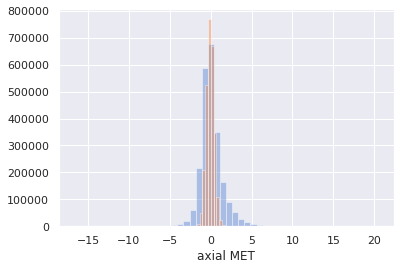

In [ ]:
sns.distplot(susy.query("signal == 1")["axial MET"], kde=False)
sns.distplot(susy.query("signal == 0")["axial MET"], kde=False)
plt.show()

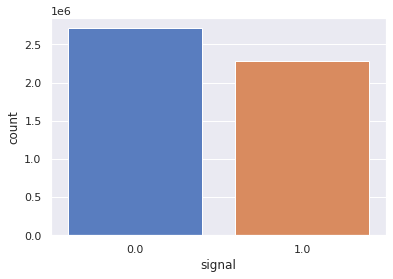

In [ ]:
sns.countplot(x="signal", data=susy)
plt.show()

####Train and Test Set

In [ ]:
susy_train = susy.copy().iloc[:4500000]
susy_test = susy.copy().iloc[-500000:]

In [ ]:
susy_train.to_feather(DATA / "susy_train.feather")

In [ ]:
susy_test.reset_index(drop=True).to_feather(DATA / "susy_test.feather")

In [ ]:
#Subsampling
susy_sample = susy_train.sample(n=500000, random_state=42)

In [ ]:
susy_sample.head(10)

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
2688763,1.0,0.821395,-0.103436,0.168752,1.051992,0.431800,-1.210648,0.428240,-1.663188,0.475450,-0.020242,0.795758,0.704858,0.786029,0.776712,0.792950,0.623655,0.770409,0.196300
491106,1.0,0.907188,-1.143420,1.317695,1.299381,-1.839876,-0.160823,0.988608,-0.829973,1.395849,-0.646217,0.963228,1.139413,1.049706,1.399592,1.019565,1.157555,1.484495,0.179817
1774899,0.0,0.659807,-1.977303,-1.410509,0.990329,-1.701409,0.249222,0.499979,-0.509796,0.737884,0.661397,0.659569,0.609093,0.819481,0.000000,0.671145,0.397877,1.439343,0.054367
1272686,0.0,0.720814,-0.863228,0.222717,0.502039,0.472637,-1.134090,0.829423,-1.630658,0.984676,-0.509003,0.685277,0.898880,1.163993,0.885574,0.733956,0.942846,1.475507,0.365486
4332815,1.0,0.672261,1.264989,-0.032661,0.560856,0.086291,1.542801,1.705778,0.219045,1.099387,2.002287,0.646456,0.835348,1.146685,0.000000,0.692432,0.779301,1.543818,0.308604
2244304,0.0,0.628619,0.341297,0.871124,0.937465,-0.337084,-0.975160,0.066713,1.445572,0.085823,0.383126,0.672370,0.210262,0.277504,0.000000,0.671088,0.047746,0.072673,0.014364
758270,1.0,0.948072,0.565038,1.400659,1.528460,0.582545,-0.981807,1.086100,-1.011808,0.108788,0.951526,0.971133,0.929972,0.849782,0.000000,0.855554,0.349060,0.883010,0.294210
2716032,1.0,0.892384,-0.861739,0.222034,0.696255,-0.641575,1.688046,1.374848,-1.481430,1.042669,-0.999751,0.687668,1.265775,1.633406,0.824735,0.812235,0.647306,1.458119,0.611218
3948794,1.0,2.128751,-0.451089,1.269205,0.438120,0.529221,-0.648973,2.559135,-0.512671,0.893488,-2.228810,1.340811,2.625525,1.737661,0.459940,1.527123,1.512763,1.426485,0.780165
2408377,0.0,0.961241,-0.758964,0.253329,0.706464,-0.192072,-1.677497,1.903260,-0.943867,2.765100,-1.136009,0.757011,1.483479,1.738976,1.503137,0.933298,1.599072,1.385127,0.496345


In [ ]:
X = susy_sample.drop("signal", axis=1)
y = susy_sample["signal"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

# picking 2 features for experimental analysis
X_train_sub = X_train[["missing energy magnitude", "lepton 1 pT"]].copy()
X_valid_sub = X_valid[["missing energy magnitude", "lepton 1 pT"]].copy()

Dataset split: 400000 train rows + 100000 valid rows


## Tree ensemble

To get started, we need a data structure that will represent an ensemble of decision trees. As a first guess, the variables we'll need to initialise our ensemble might include:

* `X`: the feature matrix
* `y`: the target vector
* `n_trees`: how many trees to include in the forest
* `sample_size`: how big we want each sample to be
* `min_samples_leaf`: some optional hyperparameter that controls the minimum number of samples required to be at a leaf node

With these considerations, let's go ahead and build our ensemble class

In [ ]:
class TreeEnsemble:
    # instance attributes
    def __init__(
        self, X: np.ndarray, y: np.ndarray, n_trees: int, sample_size: int, min_samples_leaf: int = 5,
    ):

        np.random.seed(42)
        self.X = X
        self.y = y
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.min_samples_leaf = min_samples_leaf

        self.trees = [self.create_tree() for i in range(n_trees)]

    # instance method
    def create_tree(self):
        # grab random subsample without replacement
        random_indices = np.random.permutation(len(self.y))[: self.sample_size]
        return DecisionTree(
            self.X.iloc[random_indices], self.y.iloc[random_indices], min_samples_leaf=self.min_samples_leaf,
        )

    # instance method
    def predict(self, X):
        return np.mean([t.predict(X) for t in self.trees], axis=0)

In [ ]:
class DecisionTree:
    def __init__(self, X: np.ndarray, y: np.ndarray, indices=None, min_samples_leaf: int = 5):
        self.X = X
        self.y = y
        self.indices = indices
        self.min_samples_leaf = min_samples_leaf

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
rf.trees

### Decision tree Class

In addition to passing `X`, `y`, and `min_samples_leaf` to the constructor, we also need to keep track of which row indices are passed to the left- and right-hand sides of the tree. Since the root node contains all the rows, we can use `None` as a default and set `indices` to the length of `y`:

In [ ]:
class DecisionTree:
    def __init__(self, X: np.ndarray, y: np.ndarray, indices: np.ndarray = None, min_samples_leaf: int = 5):
        if indices is None:
            indices = np.arange(len(y))

        self.X = X
        self.y = y
        self.indices = indices
        self.min_samples_leaf = min_samples_leaf

        self.n_samples, self.n_features = len(indices), X.shape[1]
        self.value = self.calculate_class_probabilities(self.y, self.indices)
        self.gini = self.gini_impurity(self.y)
        self.score = float("inf")
        self.find_feature_split()

    def find_feature_split(self):
        for i in range(self.n_features):
            self.find_better_split(i)

    def find_better_split(self, feature_index):
        pass

    def calculate_class_probabilities(self, y, indices):
        pass

    def gini_impurity(self, y):
        pass

    @property
    def split_name(self):
        return self.X.columns[self.feature_index]

    @property
    def split_feature(self):
        return self.X.values[self.indices, self.feature_index]

    @property
    def is_leaf(self):
        return self.score == float("inf")


    def __repr__(self):
        s = f"n_samples: {self.n_samples}; value: {self.value}; gini: {self.gini}"
        if not self.is_leaf:
            s += f"; score: {self.score}; feature: {self.split_name}; split_point: {self.split}"
        return s

Python `__repr__()` function returns the object representation. It could be any valid python expression such as tuple, dictionary, string etc.

This method is called when `repr()` function is invoked on the object, in that case, `__repr__()` function must return a String otherwise error will be thrown

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
rf.trees[0]

n_samples: 1000; value: None; gini: None

In [ ]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([216894, 183106]))

In [ ]:
#Normalizing the counts for simplicity
np.unique(y_train, return_counts=True)[1] / len(y_train)

array([0.542235, 0.457765])

In [ ]:
def calculate_class_probabilities(self, y: pd.Series, indices: np.ndarray):
    probs = np.unique(y.iloc[indices], return_counts=True)[1] / len(y.iloc[indices])

    # handle edge case when leaf only contains one sample
    if len(probs) == 1:
        if int(y.iloc[indices].values[0]) == 0:
            value = np.array([1.0, 0.0])
        else:
            value = np.array([0.0, 1.0])
    else:
        value = probs

    return value

In [ ]:
DecisionTree.calculate_class_probabilities = calculate_class_probabilities

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
rf.trees[0]

n_samples: 1000; value: [0.528 0.472]; gini: None

### Gini impurity

The next piece of information we need to calculate is the Gini impurity at a given node in the tree. Recall that the formula for Gini impurity is

$$ G_i = 1 - \sum_{k=1}^n p_{i,k}^2 $$

where $p_{i,k}$ is the ratio of class $k$ examples among the training examples in the ith node. We can get the values of $p_{i,k}$ by using the `np.unique` method again, e.g.

In [ ]:
y_pure = np.array([1, 1, 1, 1])
y_mixed = np.array([1, 0, 1, 0])

gini_pure = 1.0 - np.sum((np.unique(y_pure, return_counts=True)[1] / len(y_pure)) ** 2)
gini_mixed = 1.0 - np.sum((np.unique(y_mixed, return_counts=True)[1] / len(y_mixed)) ** 2)

print(f"Gini pure = {gini_pure}; Gini mixed = {gini_mixed}")

Gini pure = 0.0; Gini mixed = 0.5


In [ ]:
def gini_impurity(self, y):
    return 1.0 - np.sum((np.unique(y, return_counts=True)[1] / len(y)) ** 2)

DecisionTree.gini_impurity = gini_impurity

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=10, sample_size=1000, min_samples_leaf=3)
rf.trees[0]

n_samples: 1000; value: [0.528 0.472]; gini: 0.498432

## Finding the best split on a single branch

Here is the implementation of the logic for the `find_better_split` function.For testing,we use the same random sample from our ensemble to scikit-learns' `RandomForestClassifier`:

In [ ]:
rf = TreeEnsemble(X_train_sub, y_train, n_trees=1, sample_size=1000)
# extract DecisionTree instance
tree = rf.trees[0]
# extract sample associated with the Decision Tree
X_samp, y_samp = tree.X, tree.y
X_samp.columns

Index(['missing energy magnitude', 'lepton 1 pT'], dtype='object')

In [ ]:
model = RandomForestClassifier(n_estimators=1, max_depth=1, bootstrap=False, random_state=42, max_features=None)
model.fit(X_samp, y_samp)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
def draw_tree(fitted_model):
    
    feature_names = X_train_sub.columns
    class_names = ["Background", "Signal"]
    fig, ax = plt.subplots(figsize=(30, 10))
    plot_tree(
        fitted_model.estimators_[0],
        filled=True,
        feature_names=feature_names,
        class_names=class_names,
        ax=ax,
        fontsize=18,
        proportion=True,
    )
    plt.show()

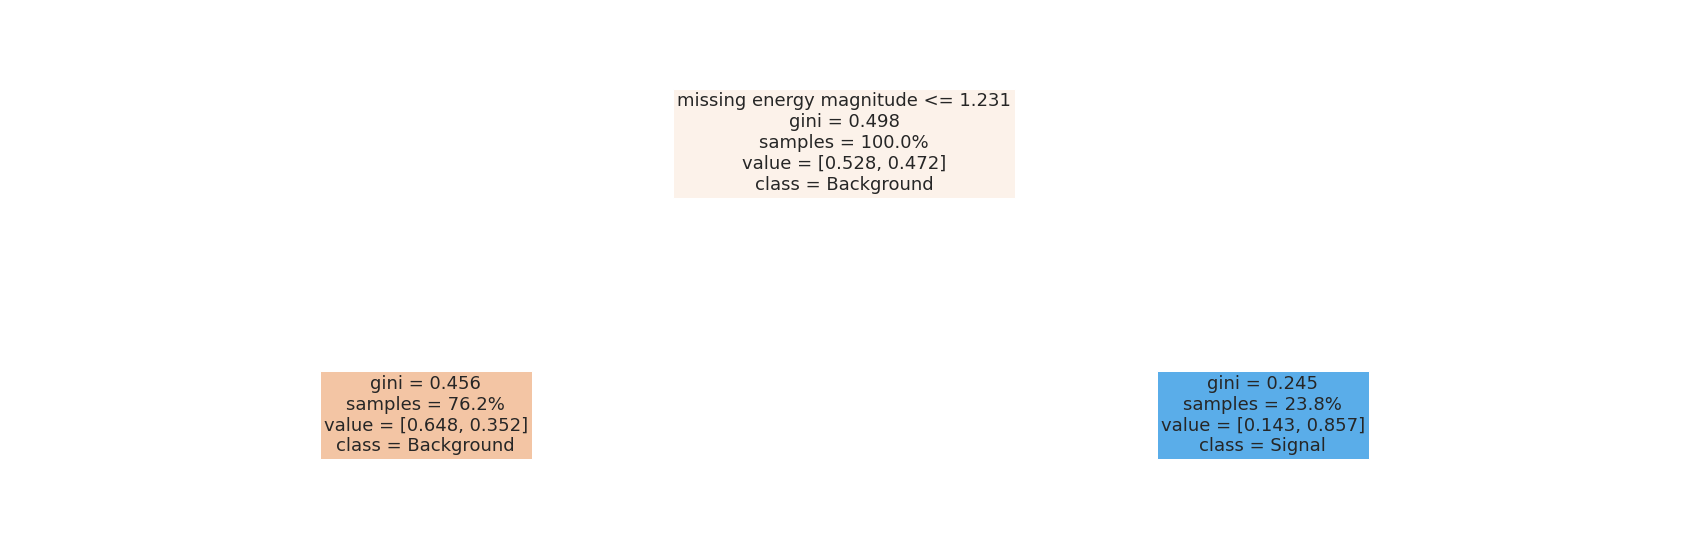

In [ ]:
draw_tree(model)

To recreate this split,scikit-learn uses the Classification And Regression Tree (CART) algorithm to train Decision Trees. Here the key idea is to search for the pair `(feature, split_point)` the produces the purest subsets, as measured by their Gini impurity. The function to minimise is given by

$$ J(k, t_k) = \frac{m_\mathrm{left}}{m} G_\mathrm{left} + \frac{m_\mathrm{right}}{m}G_\mathrm{right} $$

where $k$ is a single feature, $t_k$ is the split point (e.g. "missing energy magnitude $\leq$ 1.14), $m_\mathrm{left/right}$ is the number of examples in the left/right subset, and $G_\mathrm{left/right}$ is the Gini impurity. Thus for each feature $k$, the strategy will be to calculate $J(k, t_k)$ for every possible split point $t_k$ and update the score if it less than what we have seen already. Implemented as code, the result could look like:

In [ ]:
def find_better_split(self, feature_index):
    # get sample for a single feature
    X, y = self.X.values[self.indices, feature_index], self.y.iloc[self.indices]

    for t in range(self.n_samples):
        
        lhs = X <= X[t]
        rhs = X > X[t]

        if rhs.sum() < self.min_samples_leaf or lhs.sum() < self.min_samples_leaf:
            continue

        lhs_gini = gini_impurity(self, y[lhs])
        rhs_gini = gini_impurity(self, y[rhs])
        curr_score = lhs_gini * len(y[lhs]) / len(y) + rhs_gini * len(y[rhs]) / len(y)
  
        if curr_score < self.score:
            self.feature_index, self.score, self.split, self.gini = (
                feature_index,
                curr_score,
                X[t],
                gini_impurity(self, y),
            )

In [ ]:
%timeit find_better_split(tree, feature_index=1)
tree

1 loop, best of 3: 626 ms per loop


n_samples: 1000; value: [0.528 0.472]; gini: 0.498432; score: 0.42311509430627; feature: lepton 1 pT; split_point: 0.6449307203292847

In [ ]:
find_better_split(tree, feature_index=0)
tree

n_samples: 1000; value: [0.528 0.472]; gini: 0.498432; score: 0.40577127859017625; feature: missing energy magnitude; split_point: 1.2302938699722288

In [ ]:
tree = TreeEnsemble(X_train_sub, y_train, 1, 1000).trees[0]

In [ ]:
def find_better_split(self, feature_index):
    X, y = self.X.values[self.indices, feature_index], self.y.values[self.indices]

    sorted_indices = np.argsort(X)
    y_sorted, X_sorted = y[sorted_indices], X[sorted_indices]
    index = 0

    for i in range(0, self.n_samples - self.min_samples_leaf):
        index += 1
        Xi = X_sorted[i]
        if i < self.min_samples_leaf - 1 or Xi == X_sorted[i + 1]:
            continue

        lhs_gini = gini_impurity(self, y_sorted[:index])
        rhs_gini = gini_impurity(self, y_sorted[index:])
        curr_score = lhs_gini * len(y_sorted[:index]) / len(y_sorted) + rhs_gini * len(y_sorted[index:]) / len(y_sorted)
        
        if curr_score < self.score:
            self.feature_index, self.score, self.split, self.gini = (
                feature_index,
                curr_score,
                X_sorted[i],
                gini_impurity(self, y),
            )

In [ ]:
%timeit find_better_split(tree, feature_index=1)
tree

10 loops, best of 3: 110 ms per loop


n_samples: 1000; value: [0.528 0.472]; gini: 0.498432; score: 0.42311509430627; feature: lepton 1 pT; split_point: 0.6449307203292847

In [ ]:
find_better_split(tree, feature_index=0)
tree

n_samples: 1000; value: [0.528 0.472]; gini: 0.498432; score: 0.40577127859017625; feature: missing energy magnitude; split_point: 1.2302938699722288

In [ ]:
DecisionTree.find_better_split = find_better_split

In [ ]:
tree = TreeEnsemble(X_train, y_train, 1, 1000).trees[0]
tree

n_samples: 1000; value: [0.528 0.472]; gini: 0.498432; score: 0.40577127859017625; feature: missing energy magnitude; split_point: 1.2302938699722288

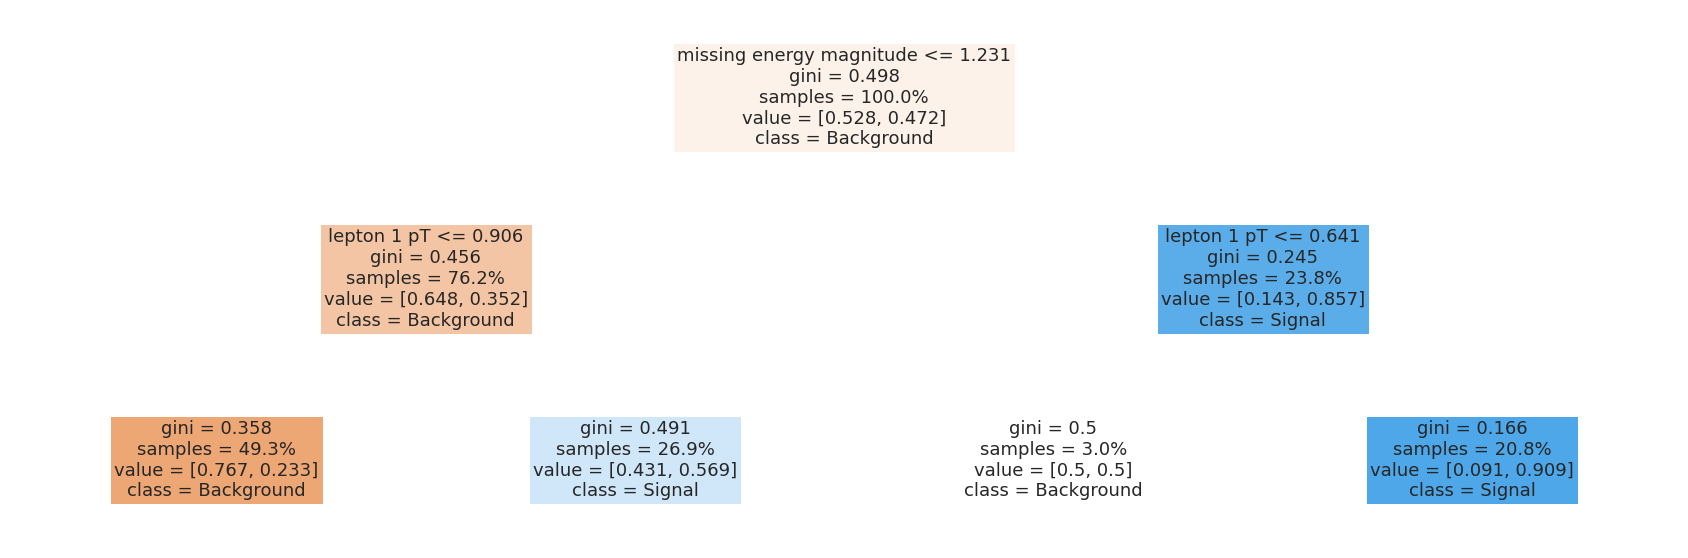

In [ ]:
model = RandomForestClassifier(n_estimators=1, max_depth=2, bootstrap=False, random_state=42, max_features=None)
model.fit(X_samp, y_samp)

draw_tree(model)

Updating the find feature split as it only checks for the best split at the root node, when in fact we need to check whether is a better split in the left and right child nodes.

In [ ]:
def find_feature_split(self):
    for i in range(self.n_features):
        self.find_better_split(i)

    if self.is_leaf:
        return

    X = self.split_feature
    # grab indices for left and right nodes
    lhs = np.nonzero(X <= self.split)[0]
    rhs = np.nonzero(X > self.split)[0]
    # recursively calculate decision trees for all nodes
    self.lhs = DecisionTree(self.X, self.y, self.indices[lhs])
    self.rhs = DecisionTree(self.X, self.y, self.indices[rhs])

In [ ]:
DecisionTree.find_feature_split = find_feature_split

In [ ]:
tree = TreeEnsemble(X_samp, y_samp, 1, 1000).trees[0]
tree

n_samples: 1000; value: [0.528 0.472]; gini: 0.498432; score: 0.40577127859017625; feature: missing energy magnitude; split_point: 1.2302938699722288

In [ ]:
tree.lhs

n_samples: 762; value: [0.64829396 0.35170604]; gini: 0.45601780092449073; score: 0.40459878571641894; feature: lepton 1 pT; split_point: 0.9052915573120116

In [ ]:
tree.rhs

n_samples: 238; value: [0.14285714 0.85714286]; gini: 0.24489795918367352; score: 0.2081043956043957; feature: lepton 1 pT; split_point: 0.6401197910308837

In [ ]:
tree.lhs.lhs

n_samples: 493; value: [0.76673428 0.23326572]; gini: 0.35770564783233016; score: 0.34452602961043255; feature: lepton 1 pT; split_point: 0.6449307203292847

In [ ]:
tree.lhs.rhs

n_samples: 269; value: [0.43122677 0.56877323]; gini: 0.4905404845151393; score: 0.4757875171199375; feature: lepton 1 pT; split_point: 1.2765909433364866

In [ ]:
tree.rhs.lhs

n_samples: 30; value: [0.5 0.5]; gini: 0.5; score: 0.2767857142857143; feature: missing energy magnitude; split_point: 1.3939119577407837

In [ ]:
tree.rhs.rhs

n_samples: 208; value: [0.09134615 0.90865385]; gini: 0.16600406804733736; score: 0.14739108429352085; feature: missing energy magnitude; split_point: 1.5202569961547852

## Generating predictions

In [ ]:
cols = ["missing energy magnitude", "lepton 1 pT", "axial MET", "M_TR_2", "M_R", "S_R"]

X_train_sub = X_train[cols].copy()
X_valid_sub = X_valid[cols].copy()

In [ ]:
%time tree = TreeEnsemble(X_train_sub, y_train, 1, 1000).trees[0]
X_samp, y_samp = tree.X, tree.y

CPU times: user 5.85 s, sys: 6.65 ms, total: 5.86 s
Wall time: 5.85 s


In [ ]:
model = RandomForestClassifier(
    n_estimators=1, max_depth=None, bootstrap=False, max_features=None, random_state=42, min_samples_leaf=5,
)
model.fit(X_samp, y_samp)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
def predict(self, X):
    return np.array([self.predict_row(Xi) for Xi in X])

DecisionTree.predict = predict

In [ ]:
def predict_row(self, Xi):
    if self.is_leaf:
        return self.value
    t = self.lhs if Xi[self.feature_index] <= self.split else self.rhs
    return t.predict_row(Xi)

DecisionTree.predict_row = predict_row

In [ ]:
%time probs = tree.predict(X_valid_sub.values)[:, 1]

CPU times: user 1 s, sys: 0 ns, total: 1 s
Wall time: 1 s


In [ ]:
roc_auc_score(y_valid, probs)

0.7530634787269814

####Comparing it with Sklearn's Prediction:

In [ ]:
probs_sklearn = model.predict_proba(X_valid_sub)[:, 1]
roc_auc_score(y_valid, probs_sklearn)

0.7491970508752992

###Result:
Our Decision tree gives nearly the same roc score as the Sklearn's Random Forest Model !!

## References


* Lessons 5 & 7 from Jeremy Howard's [_Practical Machine Learning for Coders_](http://course18.fast.ai/ml.html) course

* [_Machine Learning Recipes #8_](https://www.youtube.com/watch?time_continue=492&v=LDRbO9a6XPU&feature=emb_logo) by Josh Gordon
* [A visual introduction to machine learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) by Stephanie Yee and Tony Chu
* [_Object-Oriented Programming (OOP) in Python 3_](https://realpython.com/python3-object-oriented-programming/) by Real Python